## ANALYSIS 
 
 TOC 
  * [Intro](#intro)
  * [Setup](#setup)
  * [Functions](#functions)
  * [Input Data](#data)
  * [Analysis](#analysis)
  * [Modeling](#modeling)
 

## Introduction <a class="anchor" id="intro"></a>

**The top level workflow is the following**:

 1. Get a list of known stars to host exoplanets : (True Positives)
 
    - from NASA's exoplanets database (all corresponding to Kepler ,so belonging to only one area of the sky)
    - from TESS , how can i get them?
    - from catalogs
    
 2. Get a list of known stars -NOT- to host exoplanets (True Negatives)  
 
 3. Get the list of Gaia EDR3 objects that have RadialVelocity computed : (Why ? : because this gives a strong constrain for the 'quality' of our classifier , there should be a strong correlation between the radial velocity error and the presence of an exoplanet TODO : ARGUE THIS A BIT FURTHER)
 
 4. X-Match the list from 2 with the list from 1
 
 5  COMPUTE THE EXPECTED ASTROMETRIC SIGNATURE FROM Paper Bla as a new attribute
 
 6. Perform an attribute/feature importance check RobustFeatureEstimator over the (a subsample of) the ones that are known to host exoplanets
    to see which attrbutes have importance with respect to classification    
 
 7. Setup a verification over different classifiers

## Setup <a class="anchor" id="setup"></a>

In [1]:
# SETUP
# All notebooks must include this
import sys
import os
sys.path.append("notebooks")
ROOT_DIRECTORY=os.environ['HOME']+'/Documents/masterIA/09MAIR/'
FIGURES_DIRECTORY=ROOT_DIRECTORY + "figures/"
DATA_DIRECTORY=ROOT_DIRECTORY +"data/"

# IMPORTS
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.units as u
import astropy.coordinates as coord
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from astropy.io import ascii
from astropy.table import Table
from PyAstronomy import pyasl
# Develped Tools
from plot_tools import set_size
from plot_tools import init_sky

import warnings 
warnings.filterwarnings('ignore')

# INSTALLs (If Required)
# Astroquery installation (if required uncomment)
# !pip install astroquery

## Functions <a class="anchor" id="functions"></a>

In [2]:
def inspect_catalogs(catalogs_file='catalogs.json'):
    with open(DATA_DIRECTORY + catalogs_file, 'r') as f:
        contents = json.loads(f.read())
    return contents

def download_catalog(fetch_nb='catalog_1',catalogs=None,tables_location=None):
    from astroquery.vizier import Vizier
    # get the complete catalog
    Vizier.ROW_LIMIT = -1
    catalog_id=catalogs[fetch_nb]['id']
    print('downloading catalog : %s' %catalog_id)
    catalog_list = Vizier.find_catalogs(catalog_id)
    catalog = Vizier.get_catalogs(catalog_list.keys())
    # Inspect tables and Save them in VO format
    print('-----------------')    
    print('CATALOG :    ')
    print('info: %-10s' %my_catalogs[catalog_nb]['id'])
    print('info: %-10s' %my_catalogs[catalog_nb]['description'])
    print('info: %-10s' %my_catalogs[catalog_nb]['url'])
    print('-----------------')  
    # 3. Save tables
    print('catalog tables :')
    for tid in catalog.keys():
        print('-----------------')    
        table = catalog[tid]
        print('   table id : %s' %tid)
        print('description : %s' %table.meta['description'])
        print('columns     : %s' %table.columns)
        print('nb. of rows : %d' %len(table))
        # save
        table_name=tid.replace("/","_")+'.vot'
        table.write(tables_location + table_name , format='votable', overwrite=True)
    return catalog

### Input Catalogs

 1. Describes the local catalogs currently defined in the catalogs.json file

In [3]:
my_catalogs=inspect_catalogs()
print('currently defined catalogs :')
for cat in my_catalogs.keys():
    print('')
    print('catalog : %s' %cat)
    print('info: %-10s' %my_catalogs[cat]['id'])
    print('info: %-10s' %my_catalogs[cat]['description'])
    print('info: %-10s' %my_catalogs[cat]['url'])

currently defined catalogs :

catalog : catalog_0
info: I/350     
info: Gaia EDR3 
info: http://cdsarc.u-strasbg.fr/viz-bin/cat/I/350

catalog : catalog_1
info: J/AJ/153/136
info: Accurate empirical radii and masses of planets and their host stars with Gaia parallaxes. (2017)
info: https://cdsarc.unistra.fr/viz-bin/cat/J/AJ/153/136

catalog : catalog_2
info: J/ApJS/235/38
info: Kepler Planetary Candidates VIII . DR25
info: https://cdsarc.unistra.fr/viz-bin/cat/J/ApJS/235/38

catalog : catalog_3
info: I/298     
info: A Catalog of Northern stars with annual proper motions larger than 0.15
info: https://cdsarc.unistra.fr/viz-bin/cat/I/298

catalog : catalog_4
info: J/AJ/151/59
info: The Catalog of Earth-Like Exoplanet Survey Targets (CELESTA) a database of habitable zones around nearby stars. (2016)
info: https://cdsarc.unistra.fr/viz-bin/cat/J/AJ/151/59

catalog : catalog_5
info: J/ApJ/646/523
info: Catalog of Nearby Exoplanets
info: https://cdsarc.unistra.fr/viz-bin/cat/J/ApJ/646/523


## Input Data <a class="anchor" id="data"></a>

### Input Exoplanets Data 

 1. Fetch a specific Catalog (from_catalog=True) 
 2. OR Load Directly OpenExoplanets Catalog (from_catalog=False)
 3. Save catalog tables locally in VO format to later perform X-Match

In [4]:

# 1. catalog details
from_catalog=True      # specify if catalog is to be used (otherwise exoplanets DB will be used)
catalog_nb='catalog_1' # specify which of the catalogs from above (catalog_n) you want
catalog_tb = DATA_DIRECTORY + 'catalogs/' +  catalog_nb + '/tables/'

# 2. Fetch
if from_catalog:
    
    # download a catalog from CDS
    catalog = download_catalog(fetch_nb=catalog_nb,catalogs=my_catalogs, tables_location=catalog_tb)
    
    # specify the catalog table identifier
    catalog_key=0          
    catalog_table= catalog.keys()[catalog_key]
    exop_filename= catalog_tb + catalog_table.replace("/","_")+'.vot'
    print('')
    print('loading table from catalog : %s' %exop_filename)
    print('')  
    # Load the selected table
    votable = parse(exop_filename)
    exop_table=votable.get_first_table().to_table(use_names_over_ids=True)  
    exop_data = exop_table.to_pandas()
    
else:
    
    # Load NASA's exoplanet archive (https://exoplanetarchive.ipac.caltech.edu/ )
    from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
    exop_table=NasaExoplanetArchive.query_criteria(table="cumulative", select="*")
    
    # Select -ONLY- the NASA's exoplanet data with score > 0.9
    exop_data = exop_data.loc[exop_data['koi_score']>=0.9].reset_index(drop=True)
    
    # persist data 
    import datetime
    now = str(datetime.datetime.now())
    exop_filename=DATA_DIRECTORY+'/exoplanets/nasa_exoplanets.csv'
    print('saving exoplanet dataset to : %s' %exop_filename)
    exop_data = exop_table.to_pandas()
    exop_data.to_csv(exop_filename,index=False)

downloading catalog : J/AJ/153/136
-----------------
CATALOG :    
info: J/AJ/153/136
info: Accurate empirical radii and masses of planets and their host stars with Gaia parallaxes. (2017)
info: https://cdsarc.unistra.fr/viz-bin/cat/J/AJ/153/136
-----------------
catalog tables :
-----------------
   table id : J/AJ/153/136/Results
description : Gaia parallax data used in this study (table 4) and Results (table 7)
columns     : <TableColumns names=('Tycho','more','Name','Dist','chi2','Av','Fbol','Theta_','R_','rho_','M_','Rp','Mp','GaiaDR1','Simbad','_RA','_DE')>
nb. of rows : 498
-----------------
   table id : J/AJ/153/136/table5
description : transiting planets used in this study
columns     : <TableColumns names=('Tycho','Name','Teff','logg','__Fe_H_','Source','Porb','e','KRV','i','Depth','a_R_')>
nb. of rows : 132
-----------------
   table id : J/AJ/153/136/table6
description : radial-velocity (non-transiting) planets used in this study
columns     : <TableColumns names=('Tycho',

In [171]:
exop_table

Tycho,more,Name,Dist,chi2,Av,Fbol,Theta_,R_,rho_,M_,Rp,Mp,GaiaDR1,Simbad,_RA,_DE
,,,pc,,mag,mW / m2,uarcsec,Rsun,g / cm3,Msun,Rjup,jovMass,,,deg,deg
bytes11,bytes1,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes6,float64,float64
2-1155-1,*,WASP-32 b,232.42,0.58,0.06,7e-10,19.02,0.95,1.18,0.72,0.96,2.63,1,Simbad,3.96171,1.20044
12-104-1,*,HD 5319 b,119.64,3.03,0.06,2e-08,163.12,4.19,--,1.44,--,1.71,1,Simbad,13.75583,0.78956
30-116-1,*,WASP-71 b,299.15,0.45,0.00,1e-09,28.28,1.82,0.18,0.76,1.18,1.39,1,Simbad,29.26336,0.75885
32-383-1,*,HD 10442 b,129.65,2.31,0.06,3e-08,169.77,4.73,--,2.58,--,2.94,1,Simbad,25.47143,2.70438
88-57-1,*,WASP-82 b,277.72,0.62,0.13,3e-09,35.22,2.10,0.22,1.48,1.62,1.17,1,Simbad,72.66067,1.89391
90-645-1,*,HD 28678 b,191.09,1.41,0.18,2e-08,169.89,6.98,--,3.16,--,2.55,1,Simbad,67.85606,4.57529
96-602-1,*,GJ 179 b,--,1.04,0.00,3e-09,141.42,--,--,--,--,--,1,Simbad,73.02388,6.47655
107-1139-1,*,HD 33636 b,29.44,0.65,0.00,4e-08,159.28,1.01,--,1.34,--,11.09,1,Simbad,77.94354,4.40354


In [173]:
my_catalogs

{'catalog_0': {'id': 'I/350',
  'description': 'Gaia EDR3',
  'url': 'http://cdsarc.u-strasbg.fr/viz-bin/cat/I/350'},
 'catalog_1': {'id': 'J/AJ/153/136',
  'description': 'Accurate empirical radii and masses of planets and their host stars with Gaia parallaxes. (2017)',
  'url': 'https://cdsarc.unistra.fr/viz-bin/cat/J/AJ/153/136'},
 'catalog_2': {'id': 'J/ApJS/235/38',
  'description': 'Kepler Planetary Candidates VIII . DR25',
  'url': 'https://cdsarc.unistra.fr/viz-bin/cat/J/ApJS/235/38'},
 'catalog_3': {'id': 'I/298',
  'description': 'A Catalog of Northern stars with annual proper motions larger than 0.15',
  'url': 'https://cdsarc.unistra.fr/viz-bin/cat/I/298'},
 'catalog_4': {'id': 'J/AJ/151/59',
  'description': 'The Catalog of Earth-Like Exoplanet Survey Targets (CELESTA) a database of habitable zones around nearby stars. (2016)',
  'url': 'https://cdsarc.unistra.fr/viz-bin/cat/J/AJ/151/59'},
 'catalog_5': {'id': 'J/ApJ/646/523',
  'description': 'Catalog of Nearby Exoplanets

In [176]:
for col in exop_data.columns:
    print(type(col))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [178]:
# Show cataloge data - sorted by  Dist
if from_catalog:
    
    if my_catalogs[catalog_nb]['id'] == 'J/AJ/153/136':
        # sort by distance
        exop_data=exop_data.sort_values(by='Dist').reset_index(drop=True)
        # decode UTF-8 strings in catalog entries
        exop_data['Tycho'] = exop_data['Tycho'].str.decode('utf-8') 
        exop_data['more'] = exop_data['more'].str.decode('utf-8') 
        exop_data['Name'] = exop_data['Name'].str.decode('utf-8') 
        exop_data['Simbad'] = exop_data['Simbad'].str.decode('utf-8') 

# The first N entries sorted by distance (in pc) on this catalog     
exop_data.head(20)

,Tycho,more,Name,Dist,chi2,Av,Fbol,Theta_,R_,rho_,M_,Rp,Mp,GaiaDR1,Simbad,_RA,_DE
0,2794-157-1,*,GJ 15 A b,3.560000,6.42,0.0,5.000000e-08,472.890015,0.36,NaN,0.38,NaN,0.02,0,Simbad,4.59536,44.02296
1,4428-1943-1,*,GJ 687 b,4.540000,5.14,0.0,3.000000e-08,441.799988,0.43,NaN,0.45,NaN,0.06,0,Simbad,264.10791,68.33914
2,5819-1255-1,*,GJ 876 b,4.670000,1.70,0.0,2.000000e-08,377.299988,0.38,NaN,0.17,NaN,NaN,0,Simbad,343.31972,-14.26370
3,5227-1521-1,*,GJ 849 b,8.830000,1.79,0.0,1.000000e-08,280.119995,0.53,NaN,0.65,NaN,1.00,0,Simbad,332.41810,-4.64074
4,7220-1321-1,*,GJ 433 b,9.130000,1.19,0.0,1.000000e-08,255.089996,0.50,NaN,0.59,NaN,0.02,1,Simbad,173.86228,-32.53997
5,1275-2034-1,*,GJ 176 b,9.410000,2.15,0.0,1.000000e-08,227.649994,0.46,NaN,0.24,NaN,NaN,0,Simbad,70.73240,18.95817
6,2063-479-1,*,GJ 649 b,10.380000,2.99,0.0,1.000000e-08,225.460007,0.50,NaN,0.29,NaN,NaN,1,Simbad,254.53687,25.74416
7,8048-1022-1,*,GJ 86 b,11.250000,3.06,0.0,1.000000e-07,320.070007,0.77,NaN,0.93,NaN,4.42,0,Simbad,32.60811,-50.82376
8,7706-1752-1,*,HD 85512 b,11.320000,4.96,0.0,4.000000e-08,293.209991,0.71,NaN,0.43,NaN,0.01,1,Simbad,147.77938,-43.50278
9,6209-1322-1,*,HIP 79431 b,14.650000,2.53,0.0,4.000000e-09,172.899994,0.54,NaN,0.34,NaN,NaN,1,Simbad,243.17409,-18.87551


## Load Input Gaia Data

### Get Gaia EDR3 Data

A query is performed for stars with computed RadialVelocity.
TODO : Explain Why


The full catalog is too big for getting the whole set.
We start with something around the specified center of field of view  :

Example  : NASA's Kepler Center FoV
RA : 19h 22m 40s Dec : +44 30' 00" 

In [9]:
# Coordinates of NASA's Kepler FoV center
kepler_fov = "19 22 30 +44 30 00"
# Obtain decimal representation
ra, dec = pyasl.coordsSexaToDeg(kepler_fov)
print("Coordinates of Kepler's FOV center  [deg]: %010.6f  %+09.6f" % (ra, dec))
# Convert back into sexagesimal representation
sexa = pyasl.coordsDegToSexa(ra, dec)
print("Coordinates of Kepler's FOV center [sexa]: ", sexa)

Coordinates of Kepler's FOV center  [deg]: 290.625000  +44.500000
Coordinates of Kepler's FOV center [sexa]:  19 22 30.000  +44 30 00.000


In [10]:
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
# Check ALL Archive Tables
# for table in tables:
#    print(table.name)
    
# Load source table to check columns
# table_metadata = Gaia.load_table('gaiaedr3.gaia_source')
# print(table_metadata)
# for column in table_metadata.columns:
#    print(column.name)

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [188]:
# Load from Gaia TAP service or otherwise from local file
LOAD_FROM_ARCHIVE=True

# Specify coordinates
# Andromeda RA/DEC
# ra='00:42:44'
# dec='41:30:00'

# ----- > IMPORTANT
# Constrain the query for those stars that do have RadialVelocity Computed ( Should be around 7 million)

ra='22:00:00'
dec='37:00:00'

# Specify the list of Gaia columns to retrieve
gaia_cols=[ 'ra','ra_error','dec','dec_error', \
           'parallax','parallax_error','parallax_over_error', \
           'pm','pmra','pmra_error','pmdec','pmdec_error', \
           'astrometric_n_good_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved', \
           'pseudocolour','pseudocolour_error','visibility_periods_used','ruwe','duplicated_source', \
           'phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_flux_error', \
           'phot_bp_mean_mag','phot_rp_mean_flux','phot_rp_mean_mag','phot_bp_rp_excess_factor','bp_rp', \
           'dr2_radial_velocity','dr2_radial_velocity_error','dr2_rv_nb_transits','dr2_rv_template_teff','dr2_rv_template_logg','dr2_rv_template_fe_h' \
           'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error','phot_g_mean_mag_corrected', \
           'phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected','phot_bp_rp_excess_factor_corrected']

if LOAD_FROM_ARCHIVE :
    print('querying Gaia Archive ...')
    
    # THIS LOADS FROM VIZIER
    # remove limit for the x-match number of rows and request all columns
    # vizier = Vizier(row_limit=-1,columns=gaia_cols)    
    # coord  = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
    # side = 3 # in degrees
    # gaia_results = vizier.query_region(coord, width=side*u.degree, height=side*u.degree, catalog='I/350/gaiaedr3')
    # gaia_data = gaia_results[0].to_pandas()
    
    # THIS LOADS FROM GAIA ARCHIVE DIRECTLY
    # query specification with constrains
    
    # Query1 -> all with computed Radial Velocity
    query1 = """SELECT 
    TOP 2000
    ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,
    dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,
    astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,
    astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,
    pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,
    astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,
    ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,duplicated_source,
    phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,
    phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,
    phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,
    phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,
    phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp
    FROM gaiaedr3.gaia_source
    WHERE dr2_radial_velocity is not null AND parallax>0
    """
    
    # Query1 -> the N-thousand closest ones (from descending parallax)
    N_ITEMS=2000
    query2 = """SELECT
    TOP 2000
    ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,
    dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,
    astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,
    astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,
    pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,
    astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,
    ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,duplicated_source,
    phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,
    phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,
    phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,
    phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,
    phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp
    FROM gaiaedr3.gaia_source
    WHERE parallax >= 15 ORDER BY parallax DESC
    """

    # Launch and Asynchrnous query ( because there are more than 3000 results expected )
    job = Gaia.launch_job_async(query2)
    gaia_table = job.get_results()
    
    # persist data 
    import datetime
    now = str(datetime.datetime.now())
    gaia_filename=DATA_DIRECTORY+'/gaia/gaia_query_results.csv'
    print('writing to csv file query results : ',gaia_filename)
    gaia_data = gaia_table.to_pandas()
    gaia_data.to_csv(gaia_filename,index=False)
    
else:

    filename = DATA_DIRECTORY+'/gaia/gaia_query_results.csv'
    print('reading from file : ', filename)
    gaia_table = ascii.read(filename, format='csv', delimiter=',',header_start=0) 
    gaia_data = gaia_table.to_pandas()

querying Gaia Archive ...
INFO: Query finished. [astroquery.utils.tap.core]
writing to csv file query results :  /home/aabreu/Documents/masterIA/09MAIR/data//gaia/gaia_query_results.csv


In [189]:
# Change the name of the columns to allow proper merge with Catalog data
# gaia_data= gaia_data.set_axis(gaia_cols, axis='columns')

### X-Match Known Exoplanets with Gaia Data

In [190]:
if from_catalog:
    # specify x-match keys for catalog 1 , since it is catalog dependetn
    ra_key='_RA'
    dec_key='_DE'
    print('Using Table for x-match : ' , catalog_table)
    print('Using Table RA key      : ' , ra_key)
    print('Using Table DEC key     : ' , dec_key)

Using Table for x-match :  J/AJ/153/136/Results
Using Table RA key      :  _RA
Using Table DEC key     :  _DE


In [191]:
# X-Match the selected Table to the Gaia EDR3 catalog
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad

# perform cross-match
print('doing x-match ...')
xmatch_radius = 0.5 # in arcsec

if from_catalog:
    gaia_other = XMatch.query(
                        cat1 = 'vizier:' + catalog_table,
                        cat2 = 'vizier:I/350/gaiaedr3',
                        max_distance=1.*u.arcsec, 
                        colRA1=ra_key, 
                        colDec1=dec_key,
                        colRA2='RA_ICRS',
                        colDec2='DE_ICRS')
                    
else:
    gaia_other = XMatch.query(
                             cat1 ='vizier:I/350/gaiaedr3',
                             cat2 = open(exop_filename),
                             max_distance=xmatch_radius*u.arcsec, 
                             colRA1='ra', 
                             colDec1='dec',
                             colRA2='ra',
                             colDec2='dec')
    
print('x-match done!')

# transform x-matched data to pandas df
xmtch_data = gaia_other.to_pandas()

doing x-match ...
x-match done!


In [192]:
xmtch_data=xmtch_data.sort_values(by='Dist').reset_index(drop=True)

# show only the ones from the select System
system="GJ"  # Gliese
xmtch_data.loc[xmtch_data['Name'].str.contains(system)]
#xmtch_data.head(20)

,angDist,_RAJ2000,_DEJ2000,recno,Tycho,more,Name,Dist,chi2,Av,...,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr
0,0.021480,4.595361,44.022957,161,2794-157-1,*,GJ 15 A b,3.56,6.42,0.0,...,0.002767,0.002848,0.003802,7.218567,0.002767,24407300.0,0.010,0.2532,0.2100,-0.1731
1,0.002751,264.107914,68.339141,248,4428-1943-1,*,GJ 687 b,4.54,5.14,0.0,...,0.002797,0.003111,0.003874,8.028640,0.002797,11574200.0,0.026,0.3857,0.4351,-0.0257
2,0.020395,343.319723,-14.263700,319,5819-1255-1,*,GJ 876 b,4.67,1.70,0.0,...,0.002861,0.003707,0.003934,8.875059,0.002861,5307910.0,0.025,0.6723,0.4933,0.0054
3,0.003357,332.418102,-4.640736,288,5227-1521-1,*,GJ 849 b,8.83,1.79,0.0,...,0.002840,0.003590,0.003887,9.237196,0.002840,3802490.0,0.025,0.6200,0.6086,0.2549
4,0.001470,173.862282,-32.539968,393,7220-1321-1,*,GJ 433 b,9.13,1.19,0.0,...,0.002768,0.002859,0.003788,8.896746,0.002768,5202930.0,0.014,0.3295,0.2509,-0.0620
5,0.002392,70.732396,18.958166,67,1275-2034-1,*,GJ 176 b,9.41,2.15,0.0,...,0.002804,0.003251,0.003921,9.004439,0.002804,4711630.0,0.015,0.4419,0.2638,-0.1768
6,0.001013,254.536873,25.744159,115,2063-479-1,*,GJ 649 b,10.38,2.99,0.0,...,0.002778,0.003001,0.003822,8.823617,0.002778,5565450.0,0.011,0.3339,0.4154,0.2033
7,0.285884,32.608114,-50.823756,432,8048-1022-1,*,GJ 86 b,11.25,3.06,0.0,...,0.002768,0.002928,0.003879,5.893562,0.002768,82703100.0,0.004,0.7685,0.9730,-0.4382
11,0.011496,262.546686,-51.636978,446,8354-785-1,*,GJ 676 A b,15.86,4.85,0.0,...,0.002770,0.002907,0.003838,8.866900,0.002770,5347940.0,0.002,0.5508,0.4098,-0.2068
359,0.007033,73.023883,6.476551,7,96-602-1,*,GJ 179 b,NaN,1.04,0.0,...,0.002783,0.003002,0.003844,10.714013,0.002783,975757.0,0.019,0.4152,0.3075,-0.0030


In [193]:
# TAREA DE LIMPIEZA : puede que exista mas de una estrella x-matcheada con cada Koi
# 1. Existe algun Kepler OID con mas de 1 estrella (source_id) asociada? ( esto -NO- tiene sentido ) En este caso nos quedamos con la mas cercana
# 2. Existe alguna estrella (source_id) con mas de 1 Exoplaneta asociado (kepid)?  ( esto -SI- tiene sentido )

In [194]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import astropy.coordinates as coord

def distributions(exop_data,gaia_data,ra_min=None,ra_max=None,dec_min=None,dec_max=None,ra_key=None,dec_key=None):

    exop_plx  = exop_data['parallax']
    gaia_plx  = gaia_data['parallax']
    exop_plx_e  = exop_data['parallax_error']
    gaia_plx_e  = gaia_data['parallax_error']
    
    exop_rv_e  = exop_data['dr2_radial_velocity_error']
    gaia_rv_e  = gaia_data['dr2_radial_velocity_error']
    
    gaia_ra   = gaia_data['ra']
    gaia_dec  = gaia_data['dec']
    exop_ra   = exop_data[ra_key]
    exop_dec  = exop_data[dec_key]
    gaia_color= gaia_data['Color']
    exop_color= exop_data['Color']
    gaia_absg = gaia_data['G']
    exop_absg = exop_data['G']
    
    # display
    fig, ax = plt.subplots(3,2,figsize=(8,12))

    ax[0][0].set_xlabel('DR2 RV error')
    ax[0][0].hist(gaia_rv_e,label='Gaia',density=True,bins=200,alpha=0.5)
    ax[0][0].hist(exop_rv_e,label='EXOP',density=True,bins=200,alpha=0.5)
    ax[0][0].set_title('RV error')
    #ax[0][0].set_ylim([0,20])
    ax[0][0].legend()

    if ra_min==None:
        ax[0][1].set_xlabel('RA')
        ax[0][1].set_ylabel('Dec')
        ax[0][1].hist2d(gaia_ra,gaia_dec,bins=(300, 300), cmap=plt.cm.plasma);
        ax[0][1].hist2d(exop_ra,exop_dec,bins=(300, 300), cmap=plt.cm.plasma);
        ax[0][1].set_title('Gaia Sky Map');
    else:
        # display sky portion
        gaia_ra=gaia_data.loc[(gaia_data['ra']>ra_min) & (gaia_data['ra']<ra_max)]
        gaia_dec=gaia_data.loc[(gaia_data['dec']>dec_min) & (gaia_data['dec']<dec_max)]
        exop_ra=exop_data.loc[(exop_data[ra_key]>ra_min) & (exop_data[ra_key]<ra_max)]
        exop_dec=exop_data.loc[(exop_data[de_key]>dec_min) & (exop_data[de_key]<dec_max)]
        
        # re-dimension arrays for plotting
        gaia_ra_n=len(gaia_ra)
        gaia_dec_n=len(gaia_dec)
        exop_ra_n=len(gaia_ra)
        exop_dec_n=len(gaia_dec)
        
        gaia_ra=gaia_ra.head(len(gaia_dec))
        exop_dec=exop_dec.head(len(exop_ra))
        
        print('gaia_ra  %d' %len(gaia_ra))
        print('gaia_dec %d' %len(gaia_dec))
        print('exop_ra  %d' %len(exop_ra))
        print('exop_dec %d' %len(exop_dec))
        
        ax[0][1].set_xlabel('RA')
        ax[0][1].set_ylabel('Dec')
        ax[0][1].scatter(gaia_ra,gaia_dec,marker='o',s=5,label='Gaia');
        ax[0][1].scatter(exop_ra,exop_dec,marker='.',s=0.5,label='EXOP');
        ax[0][1].set_title('Sky Distribution');
        ax[0][1].legend()

    ax[1][0].set_xlabel('color')
    ax[1][0].hist(exop_color,alpha=0.75,density=True,label='EXOP')
    ax[1][0].hist(gaia_color,alpha=0.75,density=True,label='Gaia')
    ax[1][0].set_title('Colors')
    ax[1][0].legend()

    ax[1][1].set_xlabel('G')
    ax[1][1].hist(exop_absg,alpha=0.75,density=True,label='EXOP')
    ax[1][1].hist(gaia_absg,alpha=0.75,density=True,label='Gaia')
    ax[1][1].set_title('Absolute Magnitude')
    ax[1][1].legend()
    
    ax[2][0].set_xlabel('parallax_over_error')
    ax[2][0].hist(exop_data['parallax_over_error'],alpha=0.75,density=True,label='EXOP')
    ax[2][0].hist(gaia_data['parallax_over_error'],alpha=0.75,density=True,label='Gaia')
    ax[2][0].set_title('Parallax Over Error')
    ax[2][0].legend()

    ax[2][1].set_xlabel('phot_bp_mean_flux_error')
    ax[2][1].hist(exop_data['phot_bp_mean_flux_error'],alpha=0.75,density=True,label='EXOP')
    ax[2][1].hist(gaia_data['phot_bp_mean_flux_error'],alpha=0.75,density=True,label='Gaia')
    ax[2][1].set_title('phot_bp_mean_flux_error')
    ax[2][1].legend()
    
    plt.tight_layout()

def make_hist(x,y,ax=None,binwidth=100):
    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    # make some labels invisible
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)

    # now determine nice limits by hand:
    binwidth = binwidth
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1)*binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,alpha=0.75,density=True)
    ax_histx.set_title('Proper Motion Distributions')
    ax_histy.hist(y, bins=bins, orientation='horizontal',alpha=0.75,density=True)

def compute_color(mag_x,mag_y,mag_mean,parallax):
    # absolute magnitude is computed as : phot_g_mean_mag+5*log10(parallax)-10
    color = mag_x - mag_y
    absG  = mag_mean+5*np.log10(parallax)-10
    return color,absG
    
def physical_plots(exop_data,gaia_data,ra_key,dec_key):
    #
    # does the x-matched set make physical sense ? ( check a Hertsprung - Russel Diagram )
    
    # display
    fig, ax = plt.subplots(2,2,figsize=(12,12))
    
    exop_plx  = exop_data['parallax']
    gaia_ra   = gaia_data['ra']
    gaia_dec  = gaia_data['dec']
    gaia_color= gaia_data['Color']
    exop_color= exop_data['Color']
    gaia_absg = gaia_data['G']
    exop_absg = exop_data['G']

    # First Plot : HR DIAGRAM OF XMATCHED AND SELECTED GAIA
    
    # Calculate the point density for Gaia data
    # xy = np.vstack([gaia_color,gaia_absg])
    # z = gaussian_kde(xy)(xy)
    ax[0][0].scatter(exop_color, exop_absg, s=3, alpha=0.5 ,marker='o',zorder=1,label='EXOP data')
    ax[0][0].scatter(gaia_color, gaia_absg, s=3, alpha=0.5 ,marker='o',zorder=0,label='Gaia data')
    # ax[0][0].scatter(gaia_color,gaia_absg, color=z,s=0.1, alpha=0.5,zorder=0,label='Gaia data')
    
    ax[0][0].invert_yaxis()
    ax[0][0].set_xlabel(r'$G_{BP} - G_{RP}$')
    ax[0][0].set_ylabel(r'$M_G$')
    ax[0][0].set_xlim([-0.5,4])
    ax[0][0].set_ylim([12,-4])
    ax[0][0].set_title('Color-Magnitud Diagram')
    ax[0][0].legend()
    ax[0][0].set_axisbelow(True)
    ax[0][0].grid(True,ls='--')

    # Second Plot : scatter histogram of proper motions (exoplanet stars will likely have pm higher dispersion)

    ax[0][1].scatter(exop_data['pmra'],exop_data['pmdec'],s=10, alpha=0.5, marker='o',label='EXOP data')
    ax[0][1].scatter(gaia_data['pmra'],gaia_data['pmdec'],s=0.5, alpha=0.5, marker='o',label='Gaia data')
    make_hist(x=exop_data['pmra'],y=exop_data['pmdec'],ax=ax[0][1])
    #make_hist(x=gaia_data['pmRA'],y=gaia_data['pmDE'],ax=ax[1],color='Blue',binwidth=500)
    ax[0][1].set_xlabel('pmRa')
    ax[0][1].set_ylabel('pmDec')
    ax[0][1].set_title('Proper Motions')
    ax[0][1].legend()
    ax[0][1].set_axisbelow(True)
    ax[0][1].grid(True,ls='--')

    # Thrid Plot : Sky Distribution of Xmatched
    
    exop_ra  = coord.Angle(exop_data[ra_key]*u.degree)
    exop_ra  = exop_ra.wrap_at(180*u.degree)
    exop_dec = coord.Angle(exop_data[dec_key]*u.degree)
    gaia_ra  = coord.Angle(np.ma.array(gaia_data['ra']).filled(np.nan)*u.degree)
    gaia_ra  = gaia_ra.wrap_at(180*u.degree)
    gaia_dec = coord.Angle(np.ma.array(gaia_data['dec']).filled(np.nan)*u.degree)

    ax[1][0] = fig.add_subplot(212,projection="aitoff")
    ax[1][0].scatter(exop_ra.radian, exop_dec.radian,label='EXOP data',s=15,alpha=0.5)
    ax[1][0].scatter(gaia_ra.radian, gaia_dec.radian,label='Gaia data',s=0.1)
    ax[1][0].set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    ax[1][0].set_axisbelow(True)
    ax[1][0].grid(True,ls='--')
    ax[1][0].set_title('Sky Distribution of data');
    ax[1][0].legend();
    #ax[1][0].axis('off')


### Dataset Conditioning



In [195]:
# 1. remove all objects that don't have a parallax computed (Parallax is required to compute Absolute magnitude)
xmtch_data = xmtch_data[xmtch_data['parallax'].notnull()].reset_index(drop=True)
gaia_data = gaia_data[gaia_data['parallax'].notnull()].reset_index(drop=True)

# 2. remove Gaia useless attributes , either they contain all null values or are not usefull
# forget_attributes=['panstarrs1','sdssdr13','skymapper2','urat1']
# gaia_data=gaia_data.drop(columns=forget_attributes).reset_index(drop=True)

# 3. Compute physical quantities (color and abs mag) for catalogs
bp   = xmtch_data['phot_bp_mean_mag']
rp   = xmtch_data['phot_rp_mean_mag']
gmag = xmtch_data['phot_g_mean_mag']
plx  = xmtch_data['parallax']
xmtch_data['Color'],xmtch_data['G']  = compute_color(bp,rp,gmag,plx)

bp   = gaia_data['phot_bp_mean_mag']
rp   = gaia_data['phot_rp_mean_mag']
gmag = gaia_data['phot_g_mean_mag']
plx  = gaia_data['parallax']
gaia_data['Color'] ,gaia_data['G'] = compute_color(bp,rp,gmag,plx)

invalid_color_idxs=np.argwhere(np.isnan(np.array(gaia_data['G'])))
print('total computed colors : %d' %len(np.array(gaia_data['G'])))
print('total  invalid colors : %d' %len(invalid_color_idxs))

# 4. Remove all invalid colors
gaia_data=gaia_data[~np.isinf(np.array(gaia_data['G']))]
gaia_data=gaia_data[~np.isnan(np.array(gaia_data['G']))]
# gaia_data = gaia_data[gaia_data['G'].notna()].reset_index(drop=True)

# 5. Remove all invalid abs magnitude
gaia_data=gaia_data[~np.isnan(np.array(gaia_data['Color']))].reset_index(drop=True)

#
# 6. Add Feature : compute ASTROMETRIC SIGNATURE FEATURE
# TODO
# gaia_data['astrometric_sign']=compute_astrometric_signature(gaia_data)

total computed colors : 2000
total  invalid colors : 6


### Basic Stats

In [196]:
xmtch_data.describe()

,angDist,_RAJ2000,_DEJ2000,recno,Dist,chi2,Av,Fbol,Theta*,R*,...,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,Color,G
count,496.000000,496.000000,496.000000,496.000000,359.000000,496.000000,496.000000,4.960000e+02,496.000000,359.000000,...,496.000000,496.000000,496.000000,4.960000e+02,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,0.016826,176.808606,0.394638,250.233871,149.694457,2.070060,0.025020,6.976010e-08,188.310927,3.242451,...,0.004052,8.150417,0.002797,5.162478e+07,-0.000827,0.537096,0.482504,-0.028995,0.980920,3.813432
std,0.052110,105.885322,37.596037,144.201633,218.930771,1.796147,0.083934,1.961752e-07,240.483149,8.074582,...,0.001361,2.065607,0.000333,1.405303e+08,0.022200,0.854215,0.721748,0.248721,0.352854,1.985276
min,0.000055,1.579896,-84.231613,1.000000,3.560000,0.170000,0.000000,2.800000e-10,12.540000,0.360000,...,0.003783,2.942957,0.002757,6.157290e+03,-0.231000,0.127600,0.153900,-0.863000,0.372099,-2.324402
25%,0.001548,80.789816,-28.064396,125.750000,41.600000,0.890000,0.000000,4.000000e-09,61.447500,0.970000,...,0.003796,6.959422,0.002761,2.675048e+06,-0.003000,0.260175,0.252325,-0.195000,0.756238,3.015445
50%,0.005188,176.190469,0.774204,251.500000,76.680000,1.475000,0.000000,1.700000e-08,123.575000,1.270000,...,0.003811,7.894081,0.002765,1.310130e+07,0.000000,0.361500,0.323600,-0.027050,0.882377,3.891218
75%,0.013218,271.811239,30.526572,375.250000,188.490000,2.652500,0.010000,4.225000e-08,203.292500,1.790000,...,0.003877,9.619038,0.002775,3.098710e+07,0.002000,0.476075,0.416275,0.151725,1.114842,4.851956
max,0.771320,359.974299,85.736159,498.000000,2519.910000,12.090000,1.400000,2.000000e-06,2309.840000,71.230000,...,0.026042,16.213893,0.010082,1.252460e+09,0.225000,11.594000,10.899100,0.730000,2.809284,10.527513


In [197]:
# # do a further subset on gaia data
# from numpy import random
# size=2000
# idxs=random.choice(gaia_data.index, size=size)
# gaia_data = gaia_data.iloc[idxs,:].reset_index(drop=True)

In [198]:
gaia_data.describe()

,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,...,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,Color,G
count,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,...,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000
mean,179.371862,0.077149,-0.531291,0.072052,82.043485,0.103304,2521.788330,680.655518,11.628444,0.098719,...,5.853933,0.205822,3.497957,0.021961,1.503291,2.532390,1.412389,1.120005,2.532390,10.790634
std,102.504009,0.181577,39.353273,0.177009,43.681308,0.267728,1892.808838,721.334595,718.418276,0.225173,...,13.013892,1.670333,11.009020,0.146594,0.393885,1.108788,0.801931,0.377078,1.108788,3.450148
min,0.541358,0.006092,-86.546293,0.006862,54.735898,0.009651,16.111359,3.334469,-4406.469179,0.008231,...,0.000000,0.000000,0.000000,0.000000,0.971275,-0.348539,-1.631378,-0.231503,-0.348539,2.093760
25%,90.601041,0.017071,-31.398160,0.015980,59.700184,0.021991,1206.616699,290.186211,-303.900002,0.021959,...,0.000000,0.000000,0.000000,0.000000,1.331759,1.887877,0.860491,0.972858,1.887877,8.915486
50%,181.516032,0.024328,-1.135569,0.022301,68.180898,0.030996,2344.212891,499.236877,-3.832276,0.031533,...,1.000000,0.000000,0.000000,0.000000,1.451811,2.610692,1.396111,1.193670,2.610692,10.846306
75%,266.826261,0.048954,29.160561,0.044008,86.437906,0.061031,3388.218689,818.288528,288.040072,0.063040,...,3.000000,0.000000,1.000000,0.000000,1.542474,3.128832,1.813978,1.318765,3.128832,12.641565
max,359.967810,2.254793,85.040042,2.255087,768.066539,3.632917,15400.476562,10393.348633,6765.995136,2.978883,...,116.000000,34.000000,91.000000,1.000000,9.360927,5.263021,3.678928,2.958230,5.263021,21.663376


### Physical Sense of Input data?

 1. Catalog to Gaia X-Match Goodnes
 2. Distributions of Parallaz a Map of Gaia loaded data and histograms of computed colors and absolute magnitudes
 3. HR diagrams of Gaia and Catalog data , proper motion distributions and Sky distribution

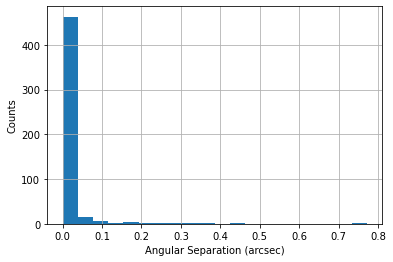

In [199]:
# check the distribution of the angular distance x-match
f,ax=plt.subplots(1,1,figsize=(6,4))
xmtch_data['angDist'].hist(ax=ax,bins=20);
#ax.set_xlim([0,0.4])
ax.set_xlabel('Angular Separation (arcsec)');
ax.set_ylabel('Counts');

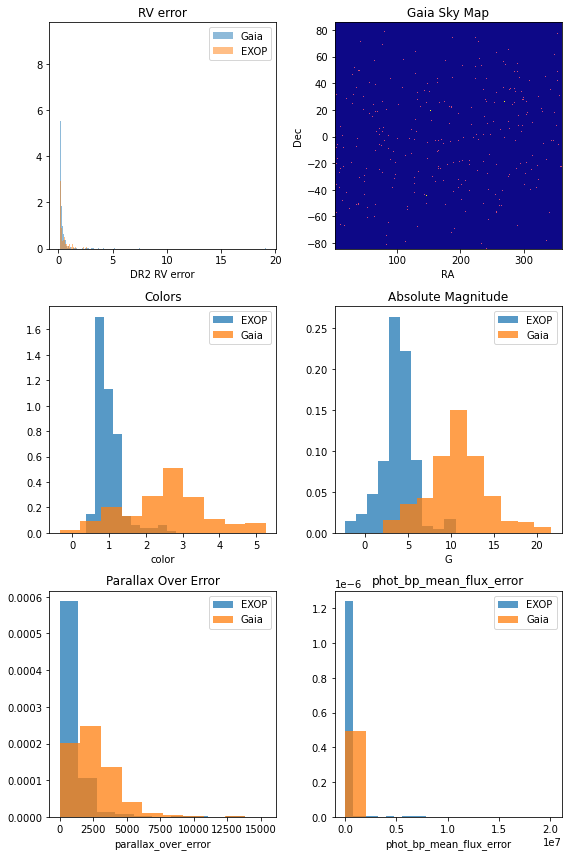

In [200]:
# limits
ra_min=285
ra_max=295
dec_min=40.5
dec_max=50.5
# distributions(exop_data=xmtch_data,gaia_data=gaia_data,ra_min=ra_min,ra_max=ra_max,dec_min=dec_min,dec_max=dec_max)
ra_key='_RA'
dec_key='_DE'
distributions(exop_data=xmtch_data,gaia_data=gaia_data,ra_key=ra_key,dec_key=dec_key)

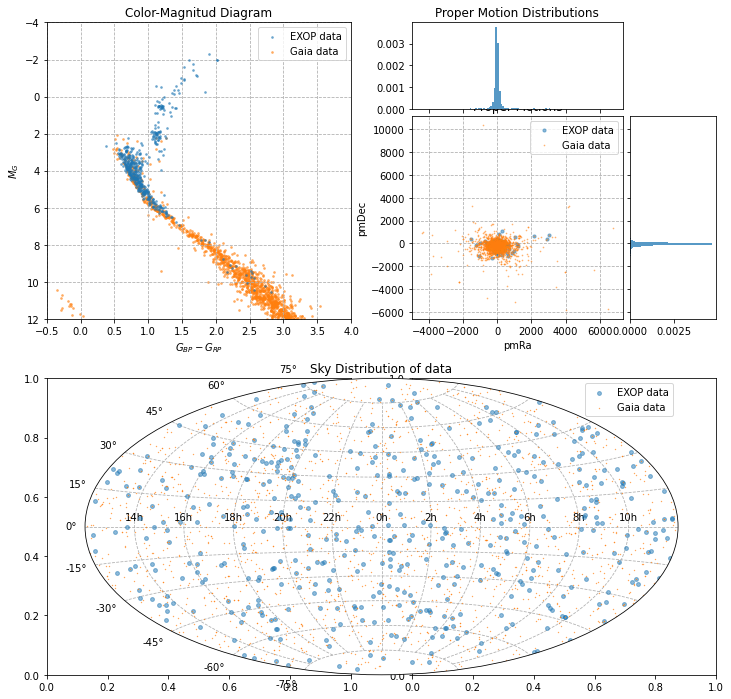

In [201]:
physical_plots(exop_data=xmtch_data,gaia_data=gaia_data,ra_key=ra_key,dec_key=dec_key)

### Data Preparation

 1. Add/Choose the target column
 2. Check if there is any start from the Gaia data that is already x-matched and should be removed 
    (this would introduce a labelling error as we are going to label the Gaia stars as not containing exoplanets) 
 3. Merge catalog and gaia data into a sinle input
 4. TODO : something else?
 
### Data Preprocessing

 1. Feature standarization
 2. Class imbalance handling
 3. TODO : something else?

In [125]:
# Merge both samples into a unique data sample for modelling
# 1. Add Target Column on each dataset
# 2. Merget them
xmtch_data['EXO']=1
gaia_data['EXO']=0

In [126]:
# How many matching columns do we have in between the tables after the update above
matching=0
for col in xmtch_data.columns:
    if col in list(gaia_data.columns):
        matching+=1
print('matching columns : %d' %matching)

matching columns : 41


In [127]:
# create  a subset of matching columns to allow the merge
gaia_cols = list(gaia_data.columns)
exop_cols = list(xmtch_data.columns)
remv_exop = []
remv_gaia = []

# Remove from EXOP data
for col in exop_cols:
    if col not in gaia_cols:
        print('column : %s , is not in Gaia data' %col)
        remv_exop.append(col)
print('will remove from exop data : ',remv_exop)

# Remove from EXOP data
for col in gaia_cols:
    if col not in exop_cols:
        print('column : %s , is not in Gaia data' %col)
        remv_gaia.append(col)
print('will remove from gaia data : ',remv_gaia)

column : angDist , is not in Gaia data
column : _RAJ2000 , is not in Gaia data
column : _DEJ2000 , is not in Gaia data
column : recno , is not in Gaia data
column : Tycho , is not in Gaia data
column : more , is not in Gaia data
column : Name , is not in Gaia data
column : Dist , is not in Gaia data
column : chi2 , is not in Gaia data
column : Av , is not in Gaia data
column : Fbol , is not in Gaia data
column : Theta* , is not in Gaia data
column : R* , is not in Gaia data
column : rho* , is not in Gaia data
column : M* , is not in Gaia data
column : Rp , is not in Gaia data
column : Mp , is not in Gaia data
column : GaiaDR1 , is not in Gaia data
column : Simbad , is not in Gaia data
column : _RA , is not in Gaia data
column : _DE , is not in Gaia data
column : ra_epoch2000 , is not in Gaia data
column : dec_epoch2000 , is not in Gaia data
column : errHalfMaj , is not in Gaia data
column : errHalfMin , is not in Gaia data
column : errPosAng , is not in Gaia data
column : source_id , i

In [128]:
# remove attribute from ctlg
exop = xmtch_data.drop(columns=remv_exop)
gaia = gaia_data.drop(columns=remv_gaia)

In [129]:
print('final attributes in gaia data : %d' %len(gaia.columns))
print('final attributes in exop data : %d' %len(exop.columns))
print('final instances  in gaia data : %d' %len(gaia))
print('final instances  in exop data : %d' %len(exop))

final attributes in gaia data : 41
final attributes in exop data : 41
final instances  in gaia data : 2000
final instances  in exop data : 496


In [130]:
# merge remaining dataframes
result = pd.concat([gaia,exop])

In [131]:
print('merged result contains : %d instances' %len(result))

merged result contains : 2496 instances


### Class Balance Check

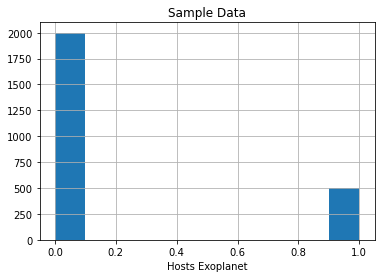

In [132]:
# Histogram
result['EXO'].hist()
plt.xlabel('Hosts Exoplanet');
plt.title('Sample Data');

### Unbalanced Data Strategies

Possible strategies to deal with the fact that we will have always inbalanced dataset 

1. Use undersampling, reduce the number of stars non-hosting planet ( caveats : may result in some unrealistic model? )
2. Use oversampling , for example with Variational Autoencoder ( otherwise also SMOTE) ( caveats : may result in some unrealistic model? )
3. Mix several exoplanet catalogs to create a more balanced dataset ? ( caveats : will end up with possibly hundreds of features )

**Tasks**:

 1. Possibly check the result of comparing from synthetic data (2) / real data(3) 
 2. (for the TFM) Explain why Gaia data is used for exoplanet detection in relation with the classification methods selected.
 3. 10% test , 10% validation 
 4. Check the model result for the first Gaia confirmed exoplanet (Image of the Week?)
 5. Possible create a new feature ( coming from the expected astrometric signature for a star hosting exoplanet )

#### Strategy 1 : Undersampling

In [133]:
# Remove a number of stats from the input to create a more balanced dataset

In [134]:
# Select a random subset from the valid ones of the given size 
# from numpy import random
# size=1000
# idxs=random.choice(result.index, size=size)
# result = result.iloc[idxs,:].reset_index(drop=True)

In [135]:
# check new balance
# Histogram
# result['EXO'].hist()
# plt.xlabel('Hosts Exoplanet');
# plt.title('Sample Data');

In [136]:
# imports necesarios
import numpy as np
import pandas as pd
from sklearn.datasets import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

 Attributes : 40 
['ra' 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pm' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'dr2_radial_velocity' 'dr2_radial_velocity_error' 'dr2_rv_nb_transits'
 'dr2_rv_template_teff' 'dr2_rv_template_logg' 'astrometric_n_good_obs_al'
 'astrometric_gof_al' 'astrometric_chi2_al' 'astrometric_excess_noise'
 'astrometric_excess_noise_sig' 'astrometric_params_solved' 'pseudocolour'
 'pseudocolour_error' 'visibility_periods_used' 'ruwe' 'duplicated_source'
 'phot_g_mean_flux' 'phot_g_mean_flux_error' 'phot_g_mean_mag'
 'phot_bp_mean_flux' 'phot_bp_mean_flux_error' 'phot_bp_mean_mag'
 'phot_rp_mean_flux' 'phot_rp_mean_mag' 'phot_bp_rp_excess_factor' 'bp_rp'
 'Color' 'G'] 

 Target : EXO

 Target possible values: [0 1]

Checking for NaNs:
Attribute                             ra has NaNs : False
Attribute                       ra_error has NaNs : False
Attribute                            dec has NaNs : False
Attribute            

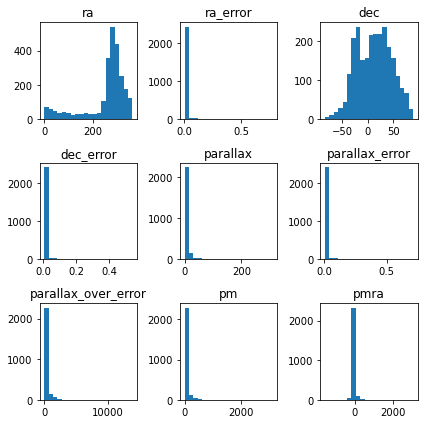

In [137]:
from prep_tools import *
# data inspection
target_name='EXO'
attributes , target  = inspect(df=result,stats=False,distro=True,target_name=target_name)

In [138]:
# Remove attributes :
# 1. That containing NaNs
# 2. That have no predicting power
# TODO : revise if this strategy is Good
# Could we substitute NaNs by a meaningfull value???
remove_attributes = ['pseudocolour','pseudocolour_error',
                     'phot_g_mean_flux','phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_mag', \
                     'phot_rp_mean_flux','phot_rp_mean_mag','phot_bp_rp_excess_factor','bp_rp', \
                     'dr2_radial_velocity','dr2_radial_velocity_error','dr2_rv_nb_transits', 'dr2_rv_template_teff','dr2_rv_template_logg']
result = result.drop(columns=remove_attributes)

# update attributes list
attributes = [attr for attr in attributes if attr not in remove_attributes]

In [139]:
print('Total Nb. of attributes : %d' %len(attributes))

Total Nb. of attributes : 25


In [145]:
# -------------------------------- #
# Funciones para preprocesar datos # 
# -------------------------------- #
def preprocess(x):
    # Standarize data , zero mean and unit variance
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    return x

def evaluate(label_real, label_pred, nClasses):
    mat = np.array([[np.sum(np.logical_and(label_real==i, label_pred==j)) 
                     for j in np.arange(nClasses)] 
                    for i in np.arange(nClasses)])
    return(mat)

def do_grid_search(clf, X, y, params_grid=None, cv=5,n_estimators=100,test_size=0.33):
   
    # partimos nuestros datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
   
    # hacemos el ajuste de parametros utilizando un grid search con los rangos establecido previamente
    gsearch = GridSearchCV(estimator = clf, param_grid = params_grid, n_jobs=4, cv=cv)
    gsearch.fit(X_train,y_train)
    
    # desplegamos los mejores parametros encontrados
    print(' -- > best score %.3f best params : %s ' %(gsearch.best_score_,gsearch.best_params_))
    return gsearch.best_params_

def do_feature_selection(df=None,filter_attributes=True):

    # ------------------------------------------------ #
    # Investigate Feature Importance
    # ------------------------------------------------ #
    # We define a set attribute seleccion tecnhniques  #
    # ------------------------------------------------ #
    # max nb. of features to select
    top_n_features = 8
    # for the RFE we need a classifier (choose and SVC)
    svc = SVC(kernel="linear", C=1)

#     attribute_selectors = {
#         'RecursiveFeatureElimination': RFE(estimator=svc, n_features_to_select=top_n_features, step=1),
#         'SelectKBest' : SelectKBest(score_func=f_classif, k=top_n_features),
#         'TreesClassifier' : ExtraTreesClassifier(n_estimators=top_n_features)
#         }
    attribute_selectors = {
        'RecursiveFeatureElimination': RFE(estimator=svc, n_features_to_select=top_n_features, step=1)
        }
    

    # data split
    X = df[attributes].values
    y = df[target].values

    # Standarize observations
    X=preprocess(x=X)

    # feature selection
    print('Selecting Attributes ...')
    relevant_attributes=select_attributes(
        X=X,
        y=y,
        selectors=attribute_selectors,
        attributes=attributes,
        sname='RecursiveFeatureElimination'
        )
    
    if filter_attributes:
        X = df[relevant_attributes].values
        y = df[target].values
    else:
        relevant_attributes=attributes

    # Save dataset for Model Training and Evaluation
    compression_opts = dict(method='zip', archive_name='input_dataset.csv')  
    out_filename=DATA_DIRECTORY+'/models/input_dataset.zip'
    df.to_csv(out_filename, index=False,compression=compression_opts)
    
    return X,y,relevant_attributes

In [146]:
X,y,final_attributes = do_feature_selection(df=result,filter_attributes=True)

Selecting Attributes ...

applying features selector : RecursiveFeatureElimination

Features Ranking  ,  [ 9  4  7  3  1 16  1  1 15 10 14  2 13  1  6  1  8 18  5 12 17  1  1  1
 11]
Features Selected ,  [ 4  6  7 13 15 21 22 23]
Feature 4 : is dec_error
Feature 6 : is parallax_error
Feature 7 : is parallax_over_error
Feature 13 : is astrometric_n_good_obs_al
Feature 15 : is astrometric_chi2_al
Feature 21 : is duplicated_source
Feature 22 : is phot_g_mean_flux_error
Feature 23 : is phot_bp_mean_flux_error


In [147]:
print('Selected Attributes are : %s' %final_attributes)

Selected Attributes are : ['dec_error', 'parallax_error', 'parallax_over_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al', 'duplicated_source', 'phot_g_mean_flux_error', 'phot_bp_mean_flux_error']


### Models

Perform a parameters grid search to identify the best set of hyper-parameters for different clasifiers:

 1. Random Forest
 2. XGBoost
 3. Simple Multilayer Perceptron (?)
 4. Naive Bayes

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [149]:
n_estimators=100
print("Number of instances : %d" %len(X))
print("Number of attributes: %d" %X.shape[1])
print("Number of estimators: %d" %n_estimators)

Number of instances : 2496
Number of attributes: 8
Number of estimators: 100


In [150]:
classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=n_estimators, max_features=1),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=1000),
    GradientBoostingClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

--------------------------------------------------------
 Doing grid search for: GradientBoostingClassifier 
---------------------------------------------------------
 -- > best score 0.982 best params : {'learning_rate': 0.05, 'max_features': 0.3, 'min_samples_leaf': 25, 'min_samples_split': 25} 
--------------------------------------------------------
 Doing grid search for: RandomForestClassifier 
---------------------------------------------------------
 -- > best score 0.980 best params : {'max_depth': 5, 'max_features': 6} 
culd not display for : RandomForestClassifier
--------------------------------------------------------
 Doing grid search for: DecisionTreeClassifier 
---------------------------------------------------------
 -- > best score 0.978 best params : {'max_depth': 3, 'max_features': 6} 
culd not display for : DecisionTreeClassifier
--------------------------------------------------------
 Doing grid search for: MLPClassifier 
---------------------------------------

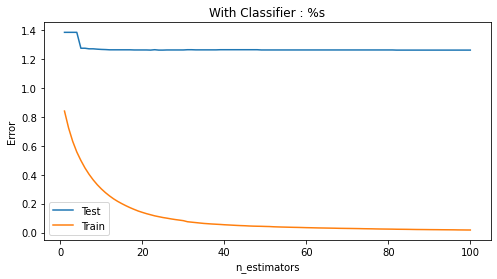

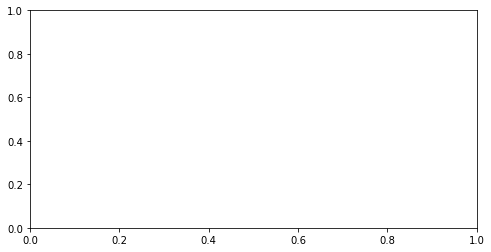

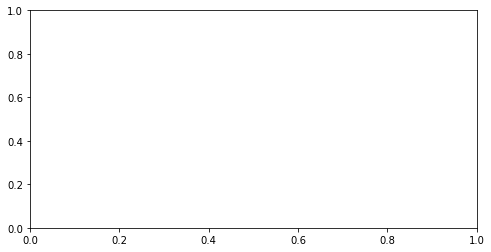

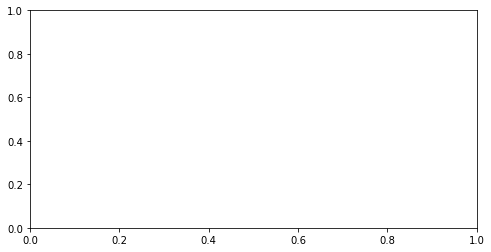

In [151]:
# Define a set of classifiers
classifiers = {
    'GradientBoostingClassifier' : GradientBoostingClassifier(n_estimators=n_estimators),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=n_estimators),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'MLPClassifier': MLPClassifier()
    }

# Define the numner of estimators
n_estimators=100

# Define a parameters grid of a CV grid search for each classifier
p_sets={
     'GradientBoostingClassifier' : [{
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_features': [1.0, 0.3, 0.1], 
            'min_samples_leaf': [5, 10, 25, 50],
            'min_samples_split' : [5, 10, 25, 50]
    }],
    'RandomForestClassifier' : [{
            'max_depth': [2, 3, 4 ,5], 
            'max_features': [5, 6, 7, 8]
    }],
    'DecisionTreeClassifier' : [{
            'max_depth': [2, 3, 4 ,5], 
            'max_features': [5, 6, 7, 8]
    }],
    'MLPClassifier': [{
            'alpha': [0.1, 0.5, 1.]
    }],
}

# Train , test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for item in classifiers.keys(): 
    clf = classifiers[item]
    p_grid = p_sets[item]
    # ----------------------------------------------------- # 
    # Hacemos un grid search para buscar mejores parametros #
    # ----------------------------------------------------- # 
    print('--------------------------------------------------------')
    print(' Doing grid search for: %s ' %item)
    print('---------------------------------------------------------')
    best_params= do_grid_search(
        X=X,
        y=y.ravel(),
        clf=clf,
        params_grid=p_grid,
        n_estimators=n_estimators
        )
    
    # use the best fit params for the fit
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
   
    # ----------------------------------------------------- # 
    # comprobamos el rendimiento con los mejores parametros #
    # ----------------------------------------------------- # 
    try :
        est = clf.fit(X_train,y_train)
        f,ax = plt.subplots(1,1,figsize=(8,4))
        test_score = np.empty(len(est.estimators_))
        for i, pred in enumerate(est.staged_predict(X_test)):
            test_score[i] = est.loss_(y_test, pred)
        ax.plot(np.arange(n_estimators) + 1, test_score, label='Test')
        ax.plot(np.arange(n_estimators) + 1, est.train_score_, label='Train')
        ax.set_xlabel('n_estimators')
        ax.set_ylabel('Error')
        ax.legend();
        ax.set_title('With Classifier : %s' )
    except AttributeError:
        print('culd not display for : %s' %item)